In [2]:
# Part 1: Import Libraries and Initial Setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
import plotly.graph_objects as go
import plotly.express as px
import mysql.connector
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from hmmlearn import hmm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense





C:\Users\Dell\AppData\Local\Temp\ipykernel_18712\2703329735.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, conn)


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3195 entries, 0 to 3194
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date_id        3195 non-null   object 
 1   open           3195 non-null   float64
 2   high           3195 non-null   float64
 3   low            3195 non-null   float64
 4   close          3195 non-null   float64
 5   adj_close      3195 non-null   float64
 6   volume         3195 non-null   int64  
 7   sp_open        3195 non-null   float64
 8   sp_high        3195 non-null   float64
 9   sp_low         3195 non-null   float64
 10  sp_close       3195 non-null   float64
 11  sp_ajclose     3195 non-null   float64
 12  sp_volume      3195 non-null   int64  
 13  dj_open        3195 non-null   float64
 14  dj_high        3195 non-null   float64
 15  dj_low         3195 non-null   float64
 16  dj_close       3195 non-null   float64
 17  dj_ajclose     3195 non-null   float64

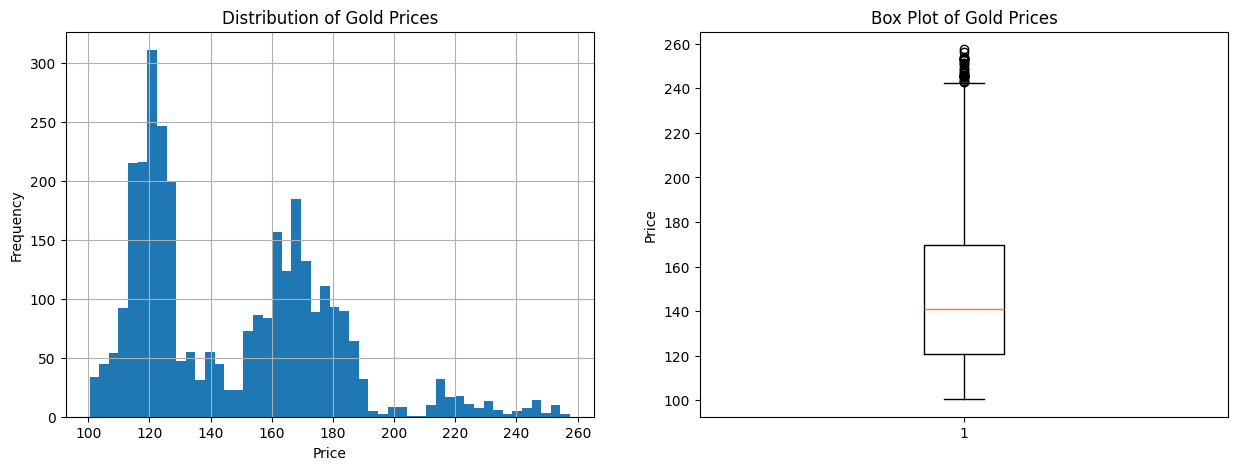

In [3]:

# Step 1: Define function to connect to the MySQL database and load data
def create_connection():
    connection = mysql.connector.connect(
        host="localhost",
        user="root",
        password="Abhi@1234",
        database="updated_gold_prediction"
    )
    return connection

def load_data_from_db():
    conn = create_connection()
    query = "SELECT * FROM merged_gold_prediction"
    data = pd.read_sql(query, conn)
    conn.close()
    return data

# Step 2: Load the data from MySQL database
data = load_data_from_db()

# Display basic information about the dataset
print("Dataset Info:")
print(data.info())
print("\nFirst few rows:")
print(data.head())
print(data.shape)

# Step 3: Plot initial data distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
data['close'].hist(bins=50)
plt.title('Distribution of Gold Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(data['close'])
plt.title('Box Plot of Gold Prices')
plt.ylabel('Price')
plt.show()


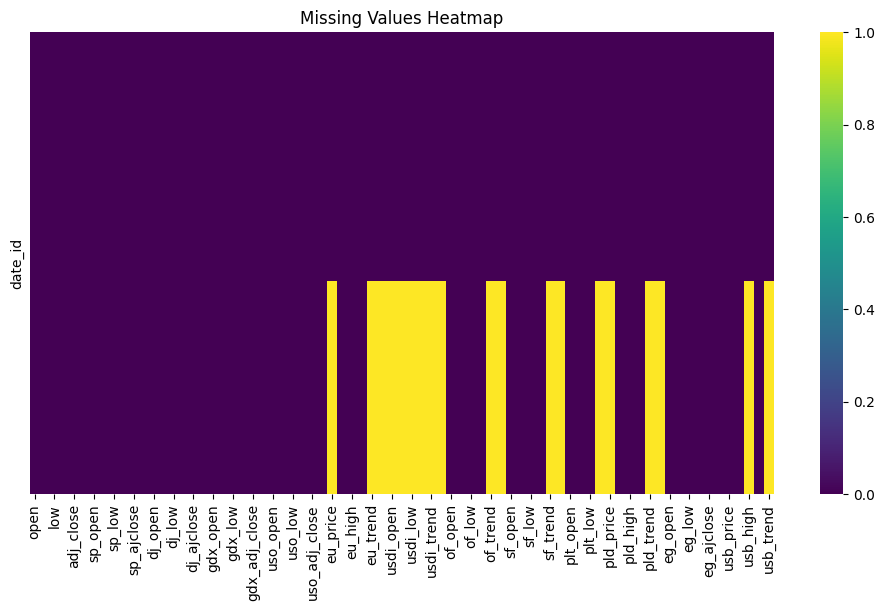


Missing value percentages:
open          0.000000
high          0.000000
low           0.000000
close         0.000000
adj_close     0.000000
               ...    
usb_price     0.000000
usb_open      0.000000
usb_high     46.228482
usb_low       0.000000
usb_trend    46.228482
Length: 75, dtype: float64
Initial shape: (3195, 75)
Missing values in each column before dropping:
open            0
high            0
low             0
close           0
adj_close       0
             ... 
usb_price       0
usb_open        0
usb_high     1477
usb_low         0
usb_trend    1477
Length: 75, dtype: int64
Shape after dropping columns with missing values: (3195, 56)
(3195, 56)


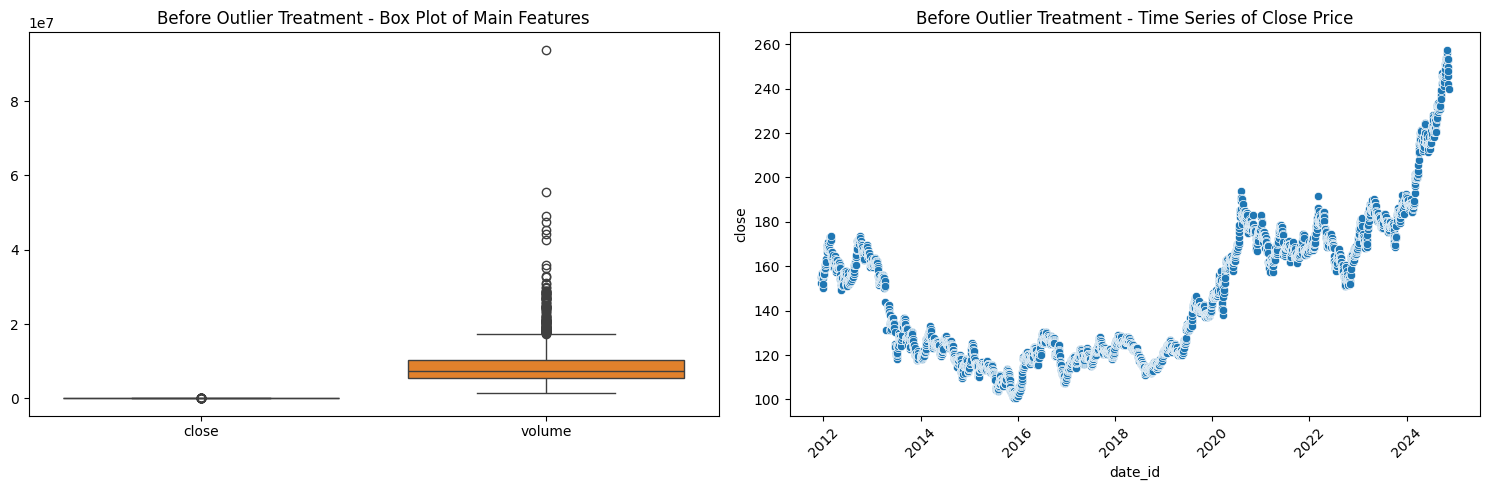

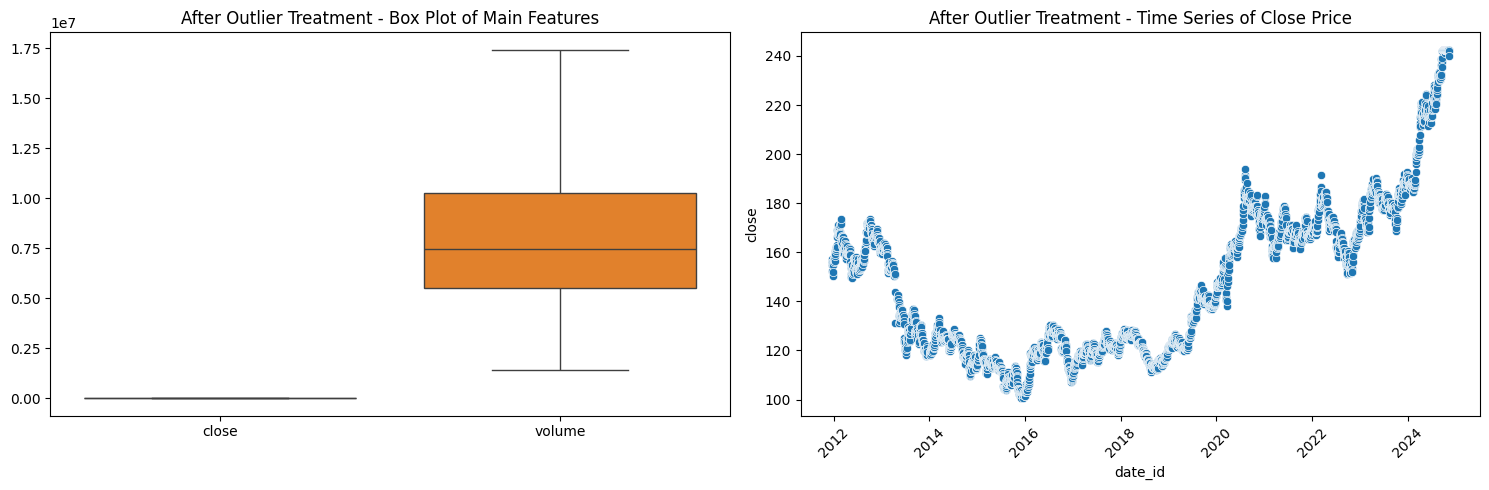

(3195, 56)

Processed Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3195 entries, 2011-12-15 to 2024-11-12
Data columns (total 56 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   open           3195 non-null   float64
 1   high           3195 non-null   float64
 2   low            3195 non-null   float64
 3   close          3195 non-null   float64
 4   adj_close      3195 non-null   float64
 5   volume         3195 non-null   int64  
 6   sp_open        3195 non-null   float64
 7   sp_high        3195 non-null   float64
 8   sp_low         3195 non-null   float64
 9   sp_close       3195 non-null   float64
 10  sp_ajclose     3195 non-null   float64
 11  sp_volume      3195 non-null   int64  
 12  dj_open        3195 non-null   float64
 13  dj_high        3195 non-null   float64
 14  dj_low         3195 non-null   float64
 15  dj_close       3195 non-null   float64
 16  dj_ajclose     3195 non-null   float64
 17

In [4]:

class GoldPricePreprocessing:
    def __init__(self):
        self.scaler = StandardScaler()
        self.price_scaler = MinMaxScaler()
    def create_es_connection():
     from elasticsearch import Elasticsearch

     es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])

     return es

    es = create_es_connection()

    def create_index(es, index_name):
        mapping = {
        "mappings": {
            "properties": {
                "field1": {"type": "text"},
                "field2": {"type": "integer"},
            }
        }
    }
    
    def load_and_clean_data(self, data):
        # Convert dates and set index
        df = data.copy()
        df['date_id'] = pd.to_datetime(df['date_id'])
        df.set_index('date_id', inplace=True)
        
        # Plot missing values
        plt.figure(figsize=(12, 6))
        sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
        plt.title('Missing Values Heatmap')
        plt.show()

        # Calculate and display missing values percentage
        missing_percentages = df.isnull().sum() / len(df) * 100
        print("\nMissing value percentages:")
        print(missing_percentages)

        # Clean data
        df = self.clean_data(df)
        print(df.shape)
        # Plot outliers before handling
        self.plot_outliers(df, 'Before Outlier Treatment')

        # Handle outliers
        numeric_columns = df.select_dtypes(include=[np.number]).columns
        for column in numeric_columns:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

        # Plot outliers after handling
        self.plot_outliers(df, 'After Outlier Treatment')

        return df

    def plot_outliers(self, df, title_prefix):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        sns.boxplot(data=df[['close', 'volume']])
        plt.title(f'{title_prefix} - Box Plot of Main Features')

        plt.subplot(1, 2, 2)
        sns.scatterplot(data=df, x=df.index, y='close')
        plt.title(f'{title_prefix} - Time Series of Close Price')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def clean_data(self, df):
        """Clean the dataset with improved NaN handling"""
        # Handle missing values
        print("Initial shape:", df.shape)
        print("Missing values in each column before dropping:")
        print(df.isnull().sum())

    # Drop columns with any missing values
        df = df.dropna(axis=1)
        print("Shape after dropping columns with missing values:", df.shape)
        return df

# Initialize preprocessor and process data
preprocessor = GoldPricePreprocessing()
processed_df = preprocessor.load_and_clean_data(data)
print(processed_df.shape)
# Display processed data info
print("\nProcessed Dataset Info:")
print(processed_df.info())


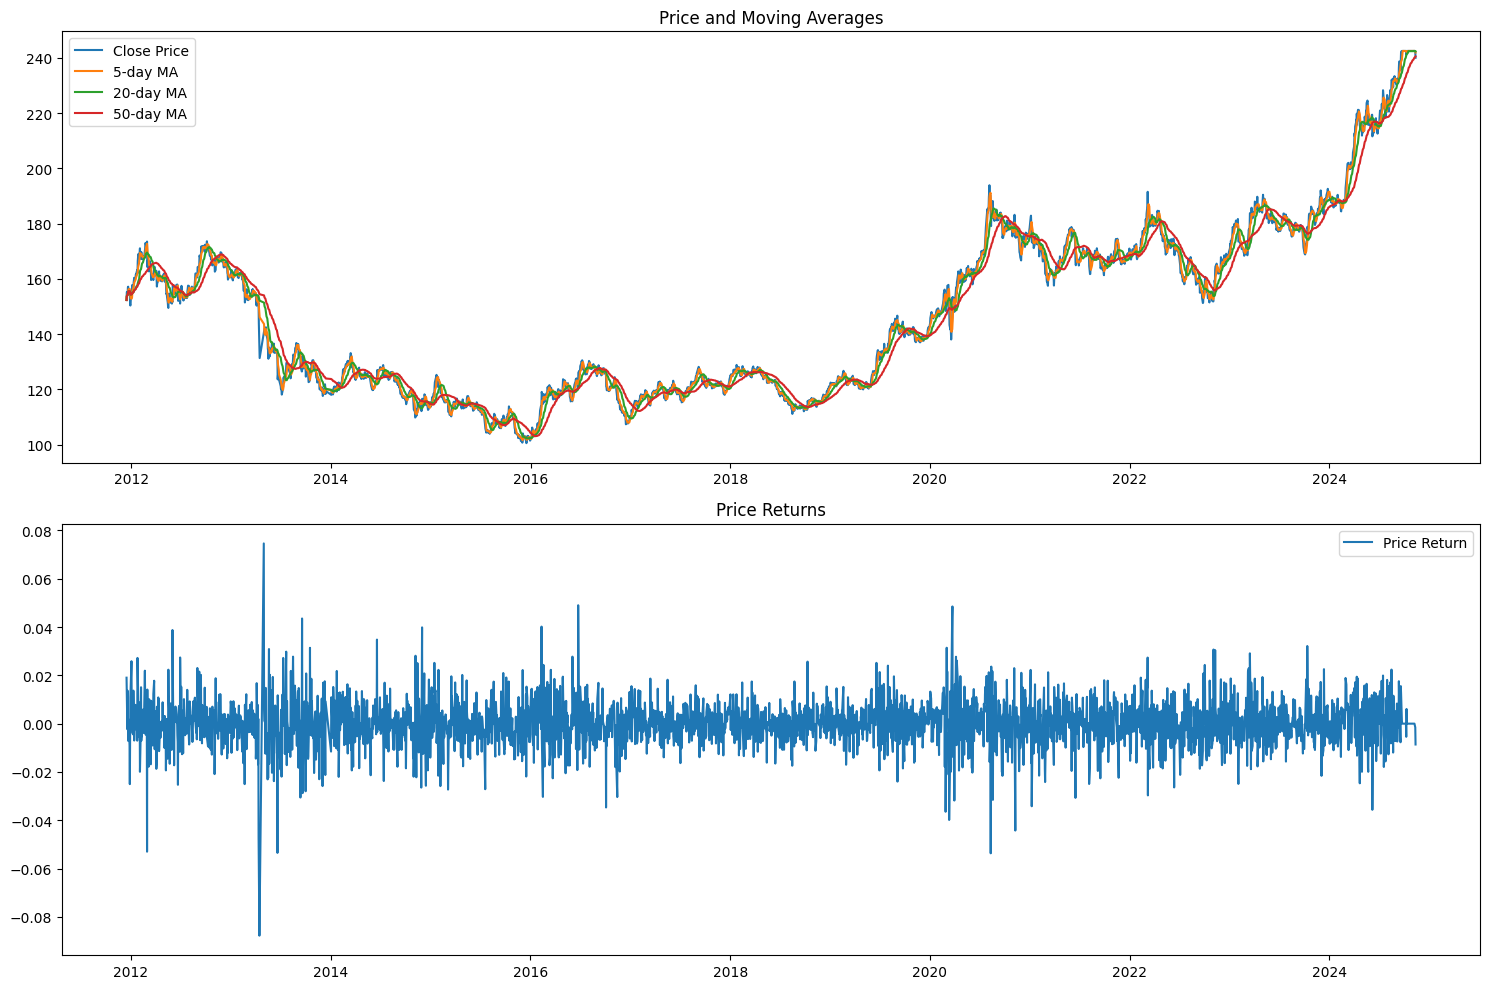

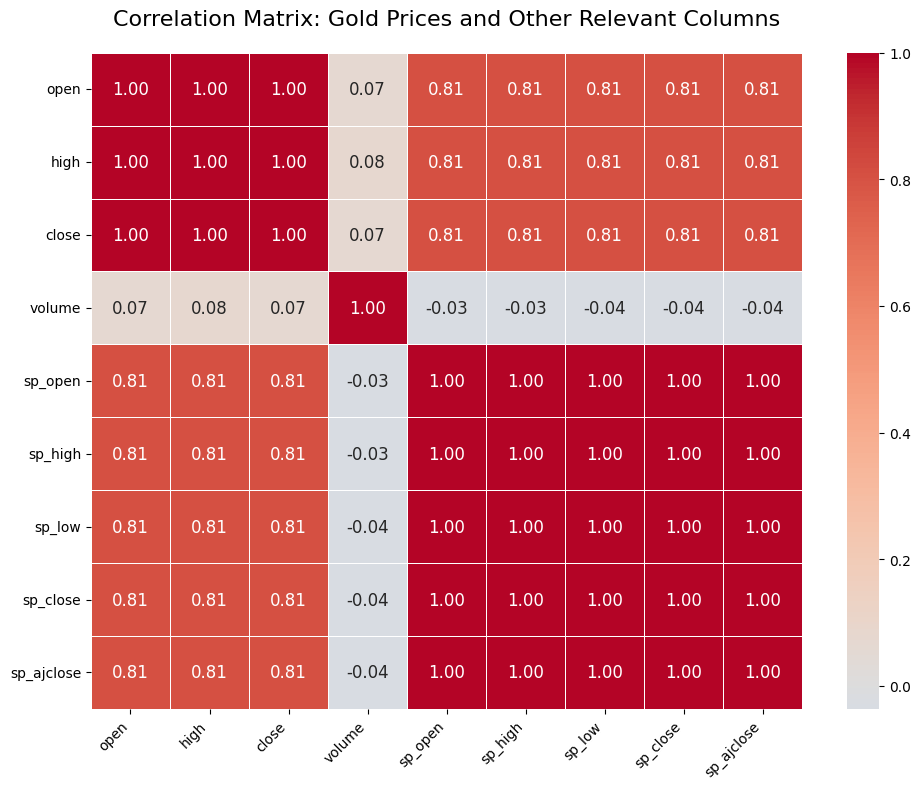

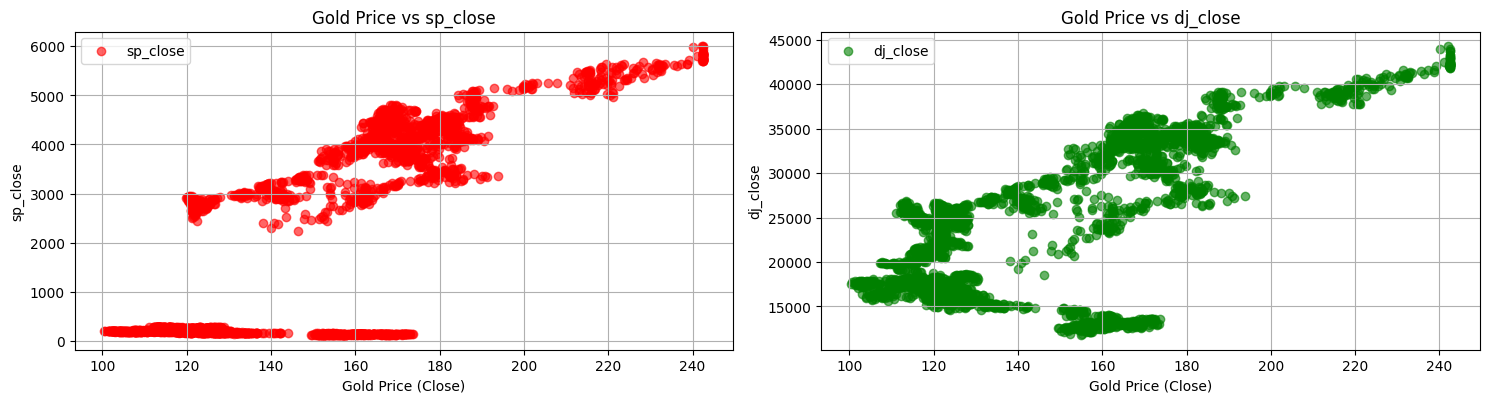

<Figure size 1500x1500 with 0 Axes>

Features retained after applying correlation threshold of 0.8:
['open', 'close', 'volume', 'dj_volume', 'gdx_open', 'gdx_volume', 'uso_open', 'uso_volume', 'eu_open', 'of_open', 'of_volume', 'plt_open', 'eg_volume', 'Price_Return', 'Volume_MA5']

Final Dataset with Features Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3195 entries, 2011-12-15 to 2024-11-12
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          3195 non-null   float64
 1   close         3195 non-null   float64
 2   volume        3195 non-null   int64  
 3   dj_volume     3195 non-null   int64  
 4   gdx_open      3195 non-null   float64
 5   gdx_volume    3195 non-null   int64  
 6   uso_open      3195 non-null   float64
 7   uso_volume    3195 non-null   int64  
 8   eu_open       3195 non-null   float64
 9   of_open       3195 non-null   float64
 10  of_volume     3195 non-null   int64  
 11  plt_open      3195 non-null   

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class FeatureEngineering1:
    @staticmethod
    def create_features(df):
        # Create technical indicators
        df_features = df.copy()

        # Price related features
        df_features['Price_Return'] = df_features['close'].pct_change()
        df_features['Price_MA5'] = df_features['close'].rolling(window=5, min_periods=1).mean()
        df_features['Price_MA20'] = df_features['close'].rolling(window=20, min_periods=1).mean()
        df_features['Price_MA50'] = df_features['close'].rolling(window=50, min_periods=1).mean()

        # Volume features (if 'volume' column exists)
        if 'volume' in df_features.columns:
            df_features['Volume_MA5'] = df_features['volume'].rolling(window=5, min_periods=1).mean()
            df_features['Volume_MA20'] = df_features['volume'].rolling(window=20, min_periods=1).mean()

        # Plot technical indicators
        plt.figure(figsize=(15, 10))

        plt.subplot(2, 1, 1)
        plt.plot(df_features.index, df_features['close'], label='Close Price')
        plt.plot(df_features.index, df_features['Price_MA5'], label='5-day MA')
        plt.plot(df_features.index, df_features['Price_MA20'], label='20-day MA')
        plt.plot(df_features.index, df_features['Price_MA50'], label='50-day MA')
        plt.title('Price and Moving Averages')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(df_features.index, df_features['Price_Return'], label='Price Return')
        plt.title('Price Returns')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # List of relevant columns for correlation matrix
        relevant_columns = [
            'open', 'high', 'close', 'volume', 
            'sp_open', 'sp_high', 'sp_low', 'sp_close', 'sp_ajclose'
        ]
        relevant_columns = [col for col in relevant_columns if col in df_features.columns]

        # Calculate and visualize the correlation matrix
        if relevant_columns:
            df_relevant = df_features[relevant_columns]
            correlation_matrix = df_relevant.corr()

            plt.figure(figsize=(10, 8))
            sns.heatmap(
                correlation_matrix, annot=True, cmap='coolwarm', center=0,
                fmt='.2f', annot_kws={'size': 12}, linewidths=0.5
            )
            plt.title('Correlation Matrix: Gold Prices and Other Relevant Columns', pad=20, size=16)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()

        # Scatter plots for Gold Price vs other assets
        assets_to_compare = ['sp_close', 'dj_close', 'eu_price', 'of_price', 'plt_price', 'pld_price', 'usdi_price']
        asset_colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink']

        plt.figure(figsize=(15, 15))
        for i, (asset, color) in enumerate(zip(assets_to_compare, asset_colors), 1):
            if asset in df_features.columns:
                plt.subplot(4, 2, i)
                plt.scatter(df_features['close'], df_features[asset], alpha=0.6, c=color, label=asset)
                plt.title(f'Gold Price vs {asset}')
                plt.xlabel('Gold Price (Close)')
                plt.ylabel(asset)
                plt.grid(True)
                plt.legend()

        plt.tight_layout()
        plt.show()

        # Scatter plots for Gold Price vs Market Sentiment Trends
        sentiment_trends = ['eu_trend', 'of_trend', 'plt_trend', 'pld_trend']
        sentiment_colors = ['cyan', 'magenta', 'yellow', 'lime']

        plt.figure(figsize=(15, 15))
        for i, (trend, color) in enumerate(zip(sentiment_trends, sentiment_colors), 1):
            if trend in df_features.columns:
                plt.subplot(4, 2, i)
                plt.scatter(df_features['close'], df_features[trend], alpha=0.6, c=color, label=trend)
                plt.title(f'Gold Price vs {trend}')
                plt.xlabel('Gold Price (Close)')
                plt.ylabel(trend)
                plt.grid(True)
                plt.legend()

        plt.tight_layout()
        plt.show()

        # Remove highly correlated features based on a threshold
        correlation_matrix = df_features.corr()
        threshold = 0.8
        correlated_features = set()

        for i in range(len(correlation_matrix.columns)):
            for j in range(i):
                colname = correlation_matrix.columns[i]
                if colname != 'close' and abs(correlation_matrix.iloc[i, j]) > threshold:
                    correlated_features.add(colname)

        remaining_features = [col for col in df_features.columns if col not in correlated_features or col == 'close']
        
        print("Features retained after applying correlation threshold of 0.8:")
        print(remaining_features)

        return df_features[remaining_features]

# Example usage
# Assuming `processed_df` is your pre-processed DataFrame
# processed_df = pd.read_csv("your_data.csv")  # Example for loading the DataFrame
feature_engineer = FeatureEngineering1()
final_df = feature_engineer.create_features(processed_df)  # Replace 'processed_df' with your actual DataFrame

# Display final dataset info
print("\nFinal Dataset with Features Info:")
print(final_df.info())



PCA Feature Contributions (Components vs Original Features):
           open      high       low  adj_close    volume   sp_open   sp_high  \
PCA_1  0.143307  0.143247  0.143436   0.143306 -0.001640  0.167361  0.167369   
PCA_2  0.130854  0.131028  0.130716   0.130933  0.038191 -0.029409 -0.029496   
PCA_3  0.023141  0.024911  0.020747   0.023106  0.324513 -0.017450 -0.016970   
PCA_4 -0.131666 -0.131429 -0.131531  -0.131543 -0.018618 -0.031224 -0.031175   
PCA_5 -0.020312 -0.016398 -0.024532  -0.021103  0.477777  0.009671  0.010233   
PCA_6 -0.011961 -0.021689 -0.022405  -0.031090 -0.013139  0.002191  0.002106   
PCA_7 -0.008235 -0.008625 -0.006605  -0.007002 -0.002784 -0.046529 -0.045796   
PCA_8 -0.163945 -0.162556 -0.161668  -0.160543 -0.024360  0.031025  0.032130   
PCA_9  0.034585  0.037592  0.034099   0.036315  0.065435  0.008287  0.009671   

         sp_low  sp_close  sp_ajclose  ...  eg_volume  usb_price  usb_open  \
PCA_1  0.167346  0.167356    0.167342  ...  -0.119233   0.1

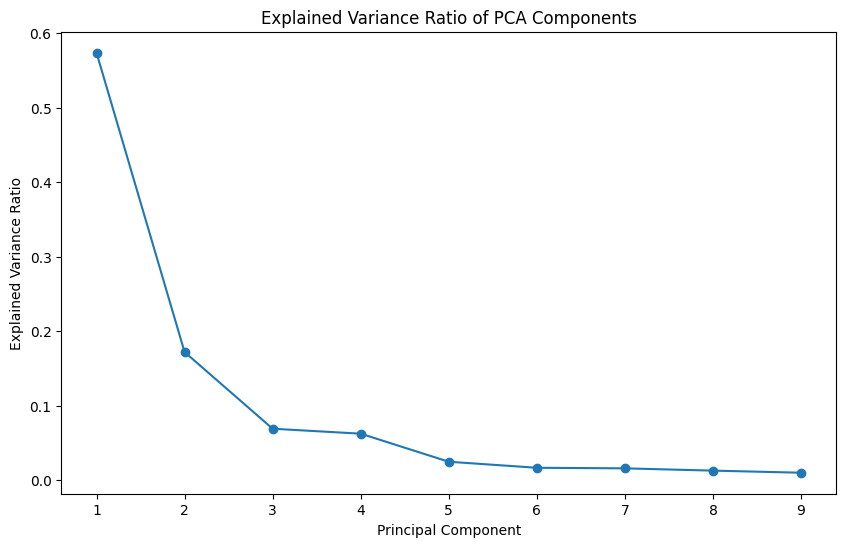


Feature Contributions to PCA Components:

PCA_1:
sp_high       0.167369
sp_open       0.167361
sp_close      0.167356
sp_low        0.167346
sp_ajclose    0.167342
                ...   
pld_open     -0.152637
sf_open      -0.152674
sf_high      -0.152686
pld_high     -0.152688
sf_low       -0.152721
Name: PCA_1, Length: 61, dtype: float64

PCA_2:
plt_low          0.261838
plt_open         0.260804
plt_high         0.259755
gdx_adj_close    0.250460
gdx_low          0.249702
                   ...   
dj_high         -0.078285
dj_volume       -0.090389
of_volume       -0.120727
uso_volume      -0.120995
gdx_volume      -0.166522
Name: PCA_2, Length: 61, dtype: float64

PCA_3:
Volume_MA20    0.385861
Volume_MA5     0.377584
volume         0.324513
gdx_high       0.174877
gdx_close      0.170793
                 ...   
of_open       -0.206552
of_low        -0.208347
eu_high       -0.216246
eu_open       -0.220215
eu_low        -0.225835
Name: PCA_3, Length: 61, dtype: float64

PCA_4:
uso

In [6]:
class FeatureEngineering2:
    @staticmethod
    def create_features(df):
        # Create technical indicators
        df_features = df.copy()
        
        # Price-related features
        df_features['Price_Return'] = df_features['close'].pct_change()
        df_features['Price_MA5'] = df_features['close'].rolling(window=5, min_periods=1).mean()
        df_features['Price_MA20'] = df_features['close'].rolling(window=20, min_periods=1).mean()
        df_features['Price_MA50'] = df_features['close'].rolling(window=50, min_periods=1).mean()
        
        # Volume features
        if 'volume' in df_features.columns:
            df_features['Volume_MA5'] = df_features['volume'].rolling(window=5, min_periods=1).mean()
            df_features['Volume_MA20'] = df_features['volume'].rolling(window=20, min_periods=1).mean()

        # Drop missing values (if any) from the dataset before applying PCA
        df_features.dropna(inplace=True)

        # Separate the features (X) and target variable (y) if necessary
        # Assuming 'close' is the target variable, else adjust accordingly
        X = df_features.drop(columns=['close'])
        
        # Standardize the features before applying PCA
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Apply PCA to reduce dimensionality
        pca = PCA(n_components=0.95)  # Retain 95% variance
        X_pca = pca.fit_transform(X_scaled)

        # Create a DataFrame for PCA components
        pca_df = pd.DataFrame(X_pca, columns=[f'PCA_{i+1}' for i in range(X_pca.shape[1])])

        # Get the loadings for each feature on the PCA components
        pca_feature_contributions = pd.DataFrame(pca.components_, columns=X.columns, index=[f'PCA_{i+1}' for i in range(X_pca.shape[1])])
        # Display the contribution of original features to each PCA component


        # Print PCA component contribution table
        print("\nPCA Feature Contributions (Components vs Original Features):")
        print(pca_feature_contributions)

        # Print the final PCA features (principal components)
        print("\nFinal PCA Features (Principal Components):")
        print(pca_df.head())  # Display the first few rows of the PCA components

        # Include the target variable 'close' in the final dataset
        final_df = pd.concat([df_features[['close']], pca_df], axis=1)

        # Plot explained variance ratio for PCA components
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
        plt.title('Explained Variance Ratio of PCA Components')
        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.show()
        print("\nFeature Contributions to PCA Components:")
        for component in pca_feature_contributions.index:
             print(f"\n{component}:")
             contributions = pca_feature_contributions.loc[component].sort_values(ascending=False)
             print(contributions)
        # Print final dataset info after applying PCA
        print("\nFinal Dataset with PCA Components Info:")
        print(final_df.info())
        # Display the contribution of original features to each PCA component
       


        return final_df

# Create features with PCA and visualize
feature_engineer = FeatureEngineering2()
final_df2 = feature_engineer.create_features(processed_df)

# Display final dataset info
print("\nFinal Dataset with Features Info:")
print(final_df2.info())


TRAINING WITH PCA FEATURE USAGE


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Evaluating XGBoost...

Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 2554, number of used features: 5
[LightGBM] [Info] Start training from score 147.335887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

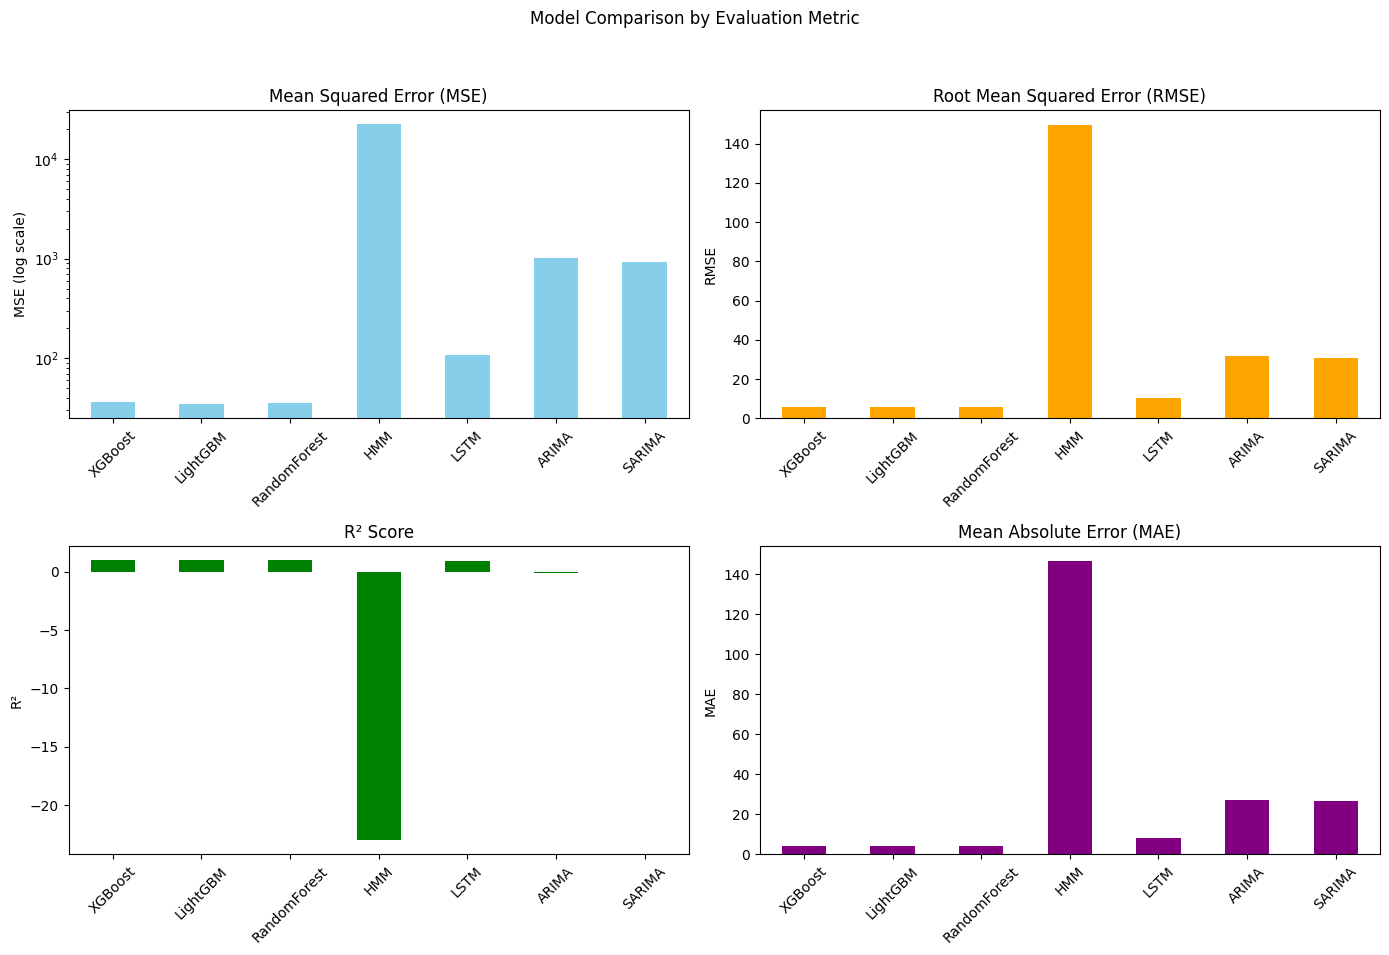

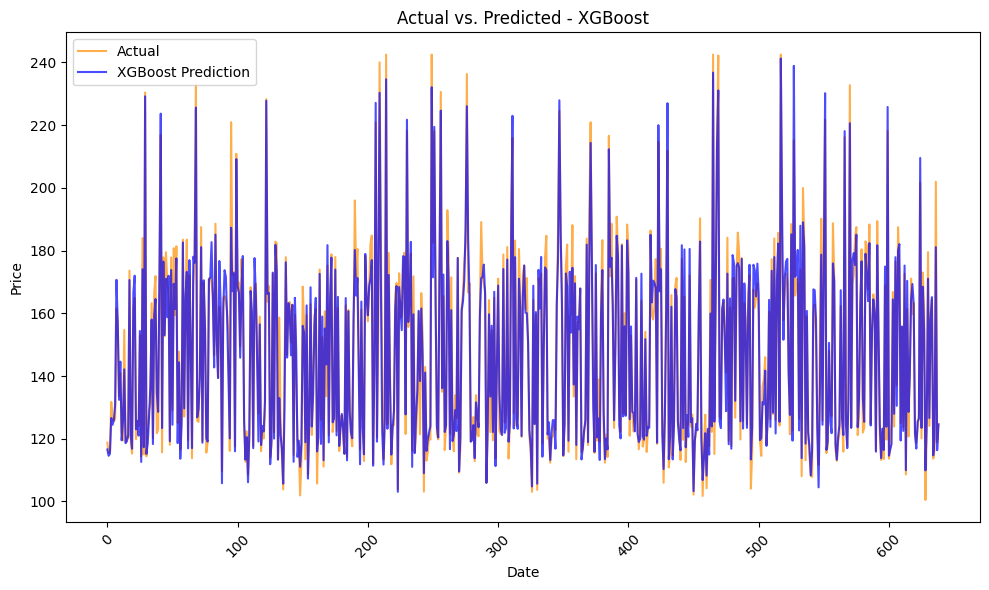

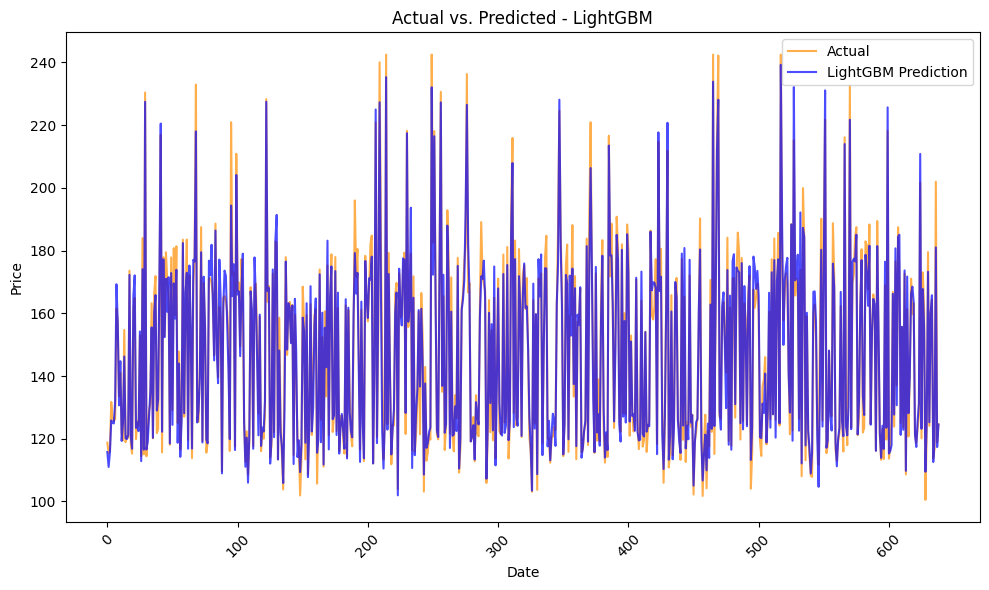

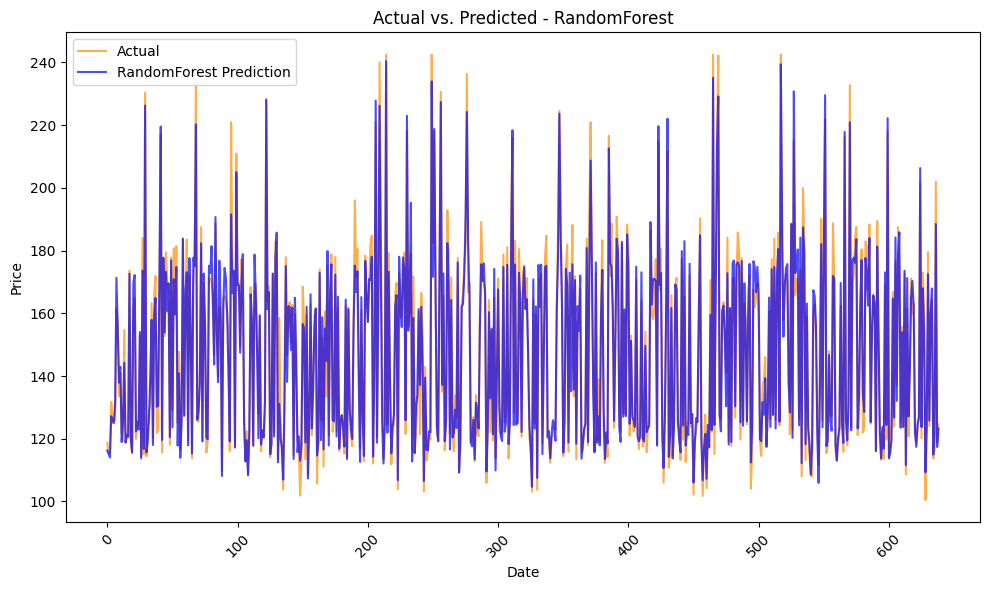

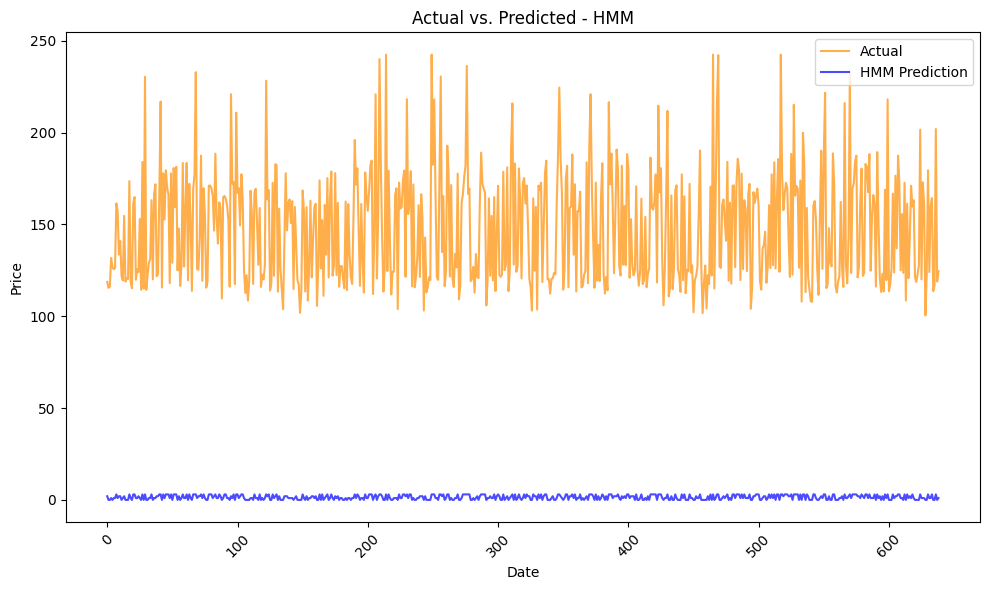

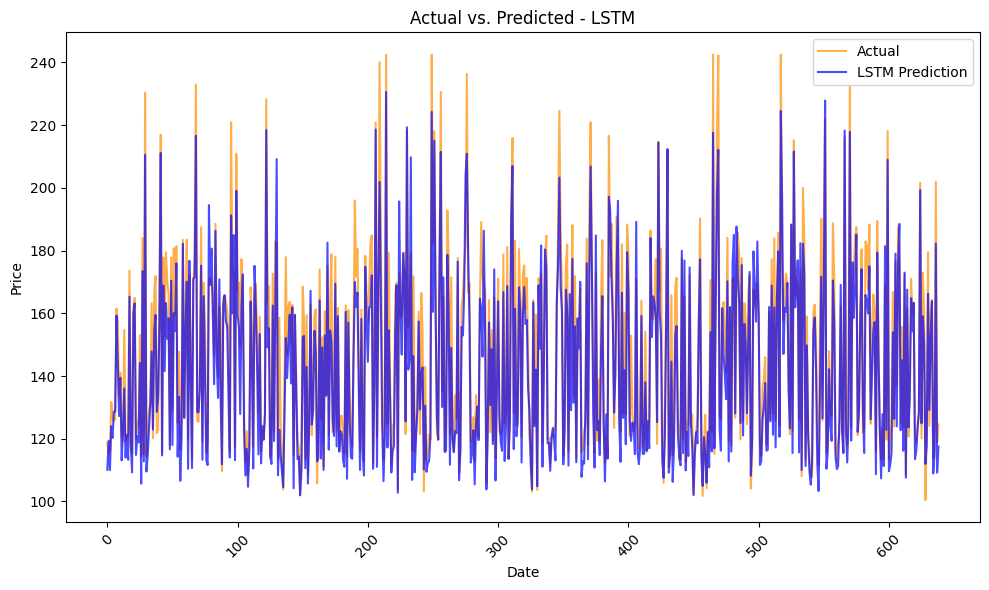

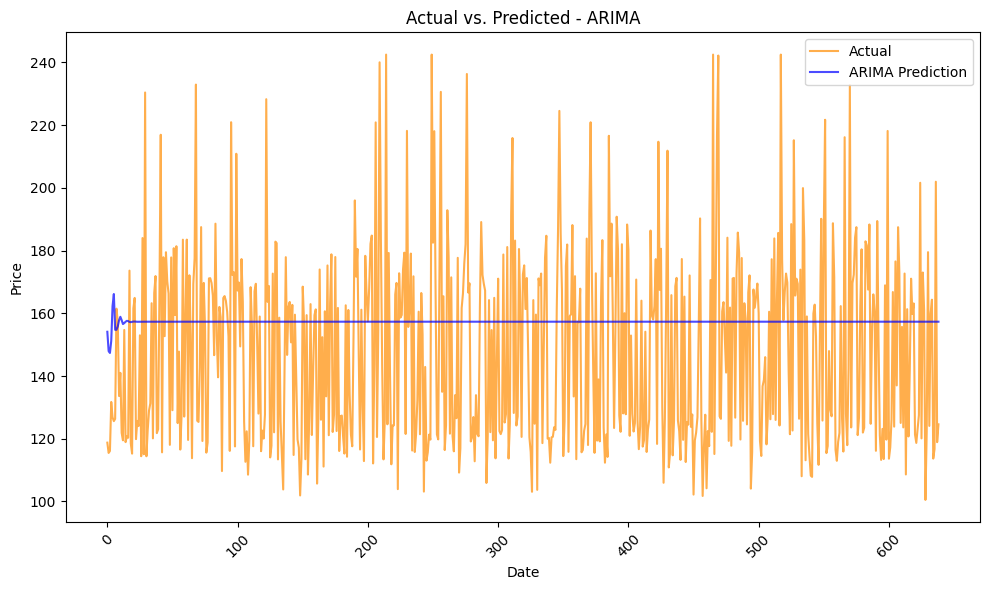

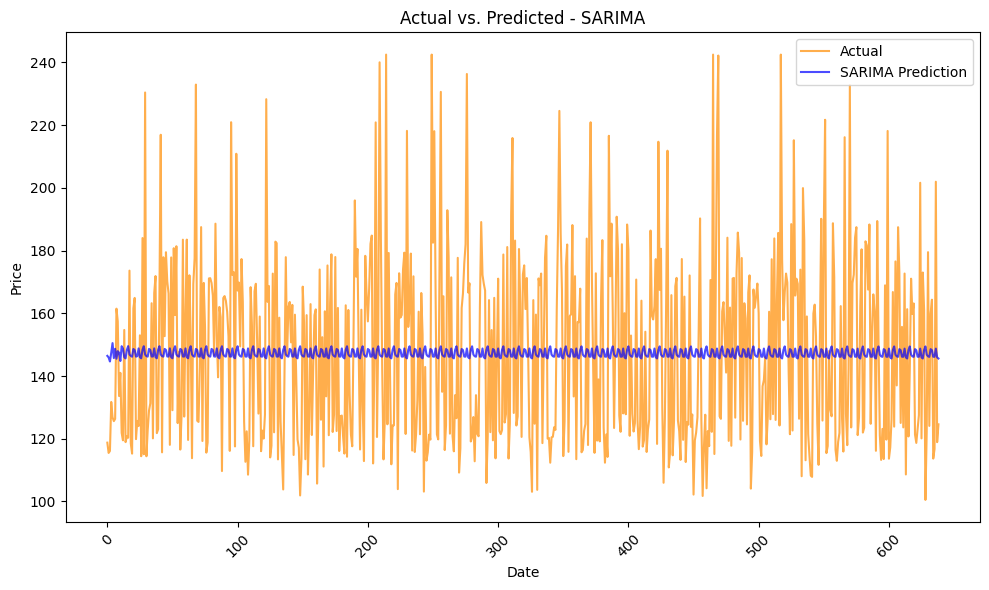


Correct Classifications within Threshold:
XGBoost: 539 correct predictions
LightGBM: 535 correct predictions
RandomForest: 534 correct predictions
HMM: 0 correct predictions
LSTM: 340 correct predictions
ARIMA: 0 correct predictions
SARIMA: 0 correct predictions

Final Model Results:
                       MSE        RMSE         R2         MAE
XGBoost          35.961812    5.996817   0.961394    4.411798
LightGBM         34.323882    5.858659   0.963152    4.424853
RandomForest     35.244551    5.936712   0.962164    4.346134
HMM           22358.288219  149.526881 -23.002180  146.575837
LSTM            108.891472   10.435108   0.883102    8.119996
ARIMA          1016.247904   31.878643  -0.090967   27.068859
SARIMA          934.260613   30.565677  -0.002952   26.520932


In [7]:
from sklearn.decomposition import PCA

class ModelTrainer:
    def __init__(self, n_components=None):
        self.scaler = StandardScaler()
        self.correct_classification_threshold = 0.05  # 5% threshold for "correct" predictions
        self.pca = PCA(n_components=n_components)

    def prepare_data(self, df):
        # Prepare features and target
        feature_columns = [col for col in df.columns if col != 'close']
        X = df[feature_columns]
        y = df['close'].shift(-1)  # Next day's closing price

        # Remove rows with NaN
        valid_rows = ~(X.isnull().any(axis=1) | y.isnull())
        X = X[valid_rows]
        y = y[valid_rows]

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Apply PCA
        X_train_pca = self.pca.fit_transform(X_train_scaled)
        X_test_pca = self.pca.transform(X_test_scaled)

        return pd.DataFrame(X_train_pca), pd.DataFrame(X_test_pca), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

    def train_hmm(self, X_train):
        model = hmm.GaussianHMM(n_components=4, covariance_type="diag", n_iter=100)
        model.fit(X_train)
        return model

    def train_lstm(self, X_train, y_train):
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
        model.fit(X_train_lstm, y_train, epochs=10, verbose=0)
        return model

    def train_arima(self, y_train):
        model = ARIMA(y_train, order=(5, 1, 0))
        model = model.fit()
        return model

    def train_sarima(self, y_train):
        model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        model = model.fit()
        return model

    def predict_lstm(self, model, X_test):
        X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
        return model.predict(X_test_lstm).flatten()

    def predict_hmm(self, model, X_test):
        return model.predict(X_test)

    def train_and_evaluate(self, X_train, X_test, y_train, y_test):
        models = {
            'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
            'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
            'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
            'HMM': self.train_hmm(X_train),
            'LSTM': self.train_lstm(X_train, y_train),
            'ARIMA': self.train_arima(y_train),
            'SARIMA': self.train_sarima(y_train)
        }

        results = {}
        predictions = {}
        correct_classifications = {}

        for name, model in models.items():
            
                print(f"\nEvaluating {name}...")
                if name == 'LSTM':
                    y_pred = self.predict_lstm(model, X_test)
                elif name == 'HMM':
                    y_pred = self.predict_hmm(model, X_test)
                elif name in ['ARIMA', 'SARIMA']:
                    y_pred = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
                else:
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)

                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                r2 = r2_score(y_test, y_pred)
                mae = mean_absolute_error(y_test, y_pred)

                correct_predictions = np.abs((y_test - y_pred) / y_test) <= self.correct_classification_threshold
                correct_classifications[name] = correct_predictions.sum()

                results[name] = {'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAE': mae}
                predictions[name] = y_pred

            

        self.plot_model_comparison(results)
        self.plot_predictions(y_test, predictions)

        print("\nCorrect Classifications within Threshold:")
        for name, count in correct_classifications.items():
            print(f"{name}: {count} correct predictions")
        
        return results, predictions

    def plot_model_comparison(self, results):
        results_df = pd.DataFrame(results).T
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        results_df['MSE'].plot(kind='bar', ax=axes[0, 0], logy=True, color='skyblue')
        axes[0, 0].set_title('Mean Squared Error (MSE)')
        axes[0, 0].set_ylabel('MSE (log scale)')
        axes[0, 0].tick_params(axis='x', rotation=45)

        results_df['RMSE'].plot(kind='bar', ax=axes[0, 1], color='orange')
        axes[0, 1].set_title('Root Mean Squared Error (RMSE)')
        axes[0, 1].set_ylabel('RMSE')
        axes[0, 1].tick_params(axis='x', rotation=45)

        results_df['R2'].plot(kind='bar', ax=axes[1, 0], color='green')
        axes[1, 0].set_title('R² Score')
        axes[1, 0].set_ylabel('R²')
        axes[1, 0].tick_params(axis='x', rotation=45)

        results_df['MAE'].plot(kind='bar', ax=axes[1, 1], color='purple')
        axes[1, 1].set_title('Mean Absolute Error (MAE)')
        axes[1, 1].set_ylabel('MAE')
        axes[1, 1].tick_params(axis='x', rotation=45)

        plt.suptitle('Model Comparison by Evaluation Metric')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def plot_predictions(self, y_test, predictions):
        for model_name, y_pred in predictions.items():
            plt.figure(figsize=(10, 6))
            plt.plot(y_test.index, y_test.values, label='Actual', color='#FF8C00', alpha=0.7, linewidth=1.5)
            plt.plot(y_test.index, y_pred, label=f'{model_name} Prediction', color='blue', alpha=0.7)
            plt.title(f'Actual vs. Predicted - {model_name}')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(f'{model_name}_prediction.png')
            plt.show()

# Usage
trainer = ModelTrainer(n_components=5)  # Specify the number of PCA components
X_train, X_test, y_train, y_test = trainer.prepare_data(final_df)
results, predictions = trainer.train_and_evaluate(X_train, X_test, y_train, y_test)
# Display final results
print("\nFinal Model Results:")
print(pd.DataFrame(results).T)

TRAINING WITHOUT PCA FEATURE USAGE


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pandas as pd
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

class DatePredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.correct_classification_threshold = 0.05  # 5% threshold for "correct" predictions
        self.models = {}  # Store trained models for later use
        self.lstm_model = None  # To store the LSTM model

    def prepare_data(self, df):
        # Prepare features and target
        feature_columns = [col for col in df.columns if col != 'close']
        X = df[feature_columns]
        y = df['close'].shift(-1)  

        # Remove rows with NaN
        valid_rows = ~(X.isnull().any(axis=1) | y.isnull())
        X = X[valid_rows]
        y = y[valid_rows]

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Scale features
        X_train_scaled = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        X_test_scaled = pd.DataFrame(
            self.scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        
        return X_train_scaled, X_test_scaled, y_train, y_test, X, y

    def train_and_store_models(self, X_train, y_train):
        # Define traditional models
        self.models = {
            'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
            'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
            'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
        }

        # Train traditional models
        for name, model in self.models.items():
            print(f"Training {name}...")
            model.fit(X_train, y_train)

        # Train LSTM
        print("Training LSTM...")
        X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))  # Reshape for LSTM
        self.lstm_model = Sequential()
        self.lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
        self.lstm_model.add(LSTM(units=50))
        self.lstm_model.add(Dense(1))
        self.lstm_model.compile(optimizer='adam', loss='mean_squared_error')
        self.lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1)

        print("\nModels trained and stored successfully.")

    def predict_for_date(self, input_date, df):
        # Ensure models are trained
        if not self.models and not self.lstm_model:
            print("Models are not trained yet. Train models before predicting.")
            return None

        # Prepare data for the given date
        if input_date not in df.index:
            print("Error: Given date not found in the dataset.")
            return None

        # Extract the feature data for the given date
        input_data = df.loc[input_date].drop('close')
        input_data_scaled = self.scaler.transform(input_data.values.reshape(1, -1))

        # Generate predictions using each model
        predictions = {}
        for name, model in self.models.items():
            predictions[name] = model.predict(input_data_scaled)[0]

        # Predict using LSTM
        input_data_lstm = input_data_scaled.reshape((1, 1, input_data_scaled.shape[1]))
        predictions['LSTM'] = self.lstm_model.predict(input_data_lstm)[0][0]

        return predictions

# Usage
# Assuming `final_df` is your prepared DataFrame with a 'close' column
trainer = DatePredictor()
X_train, X_test, y_train, y_test, X, y = trainer.prepare_data(final_df)
trainer.train_and_store_models(X_train, y_train)

# User Input Prediction
user_date = '2022-02-08'  # Replace with the desired date input
predictions = trainer.predict_for_date(user_date, final_df)

if predictions:
    print(f"\nPredictions for {user_date}:")
    for model, pred in predictions.items():
        print(f"{model}: {pred:.2f}")


Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3568
[LightGBM] [Info] Number of data points in the train set: 2554, number of used features: 14
[LightGBM] [Info] Start training from score 147.335887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 23021.0684
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21140.9551
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18866.1055
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17207.1758
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15664.5205
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14767.3633
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14007.4590
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13395.1963
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12576.2783
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11733.2383
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11392.1133
Epoch 12/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10612.7070
Epoch 13/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10128.4463
Epoch 14/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9421.0957
Epoch 15/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step

Predictions for 2022-02-08:
XGBoost: 170.03
LightGBM: 170.21
RandomForest: 169.94
LSTM: 73.18


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has


Evaluating XGBoost...

Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3568
[LightGBM] [Info] Number of data points in the train set: 2554, number of used features: 14
[LightGBM] [Info] Start training from score 147.335887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Dell\AppData\Local\Temp\ipykernel_18712\377570328.py:123: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  correct_predictions = np.abs((y_test - y_pred) / y_test) <= self.correct_classification_threshold
C:\Users\Dell\AppData\Local\Temp\ipykernel_18712\377570328.py:123: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp

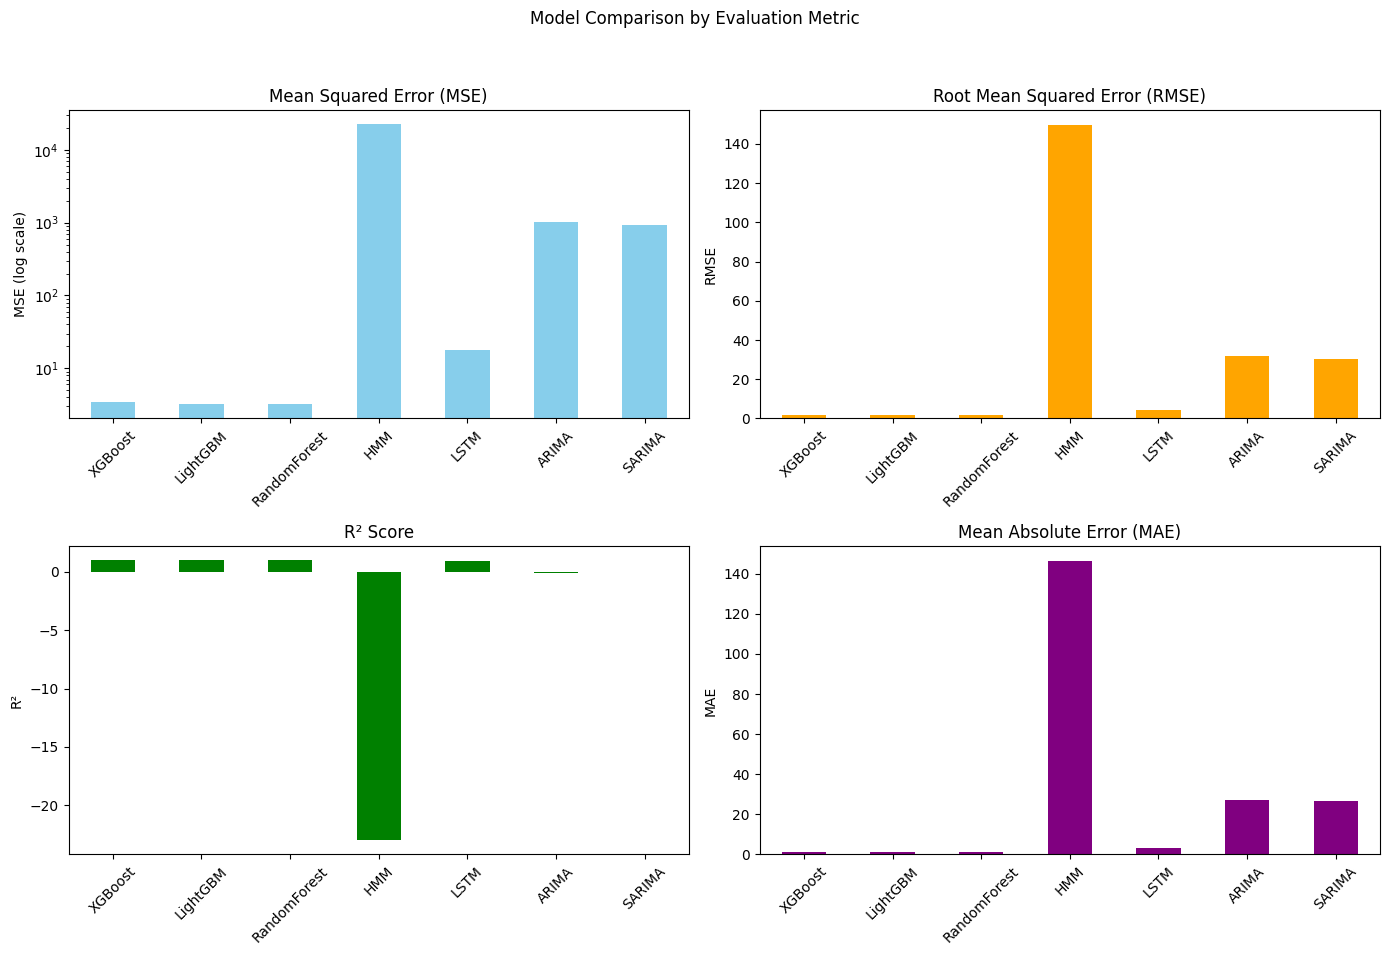

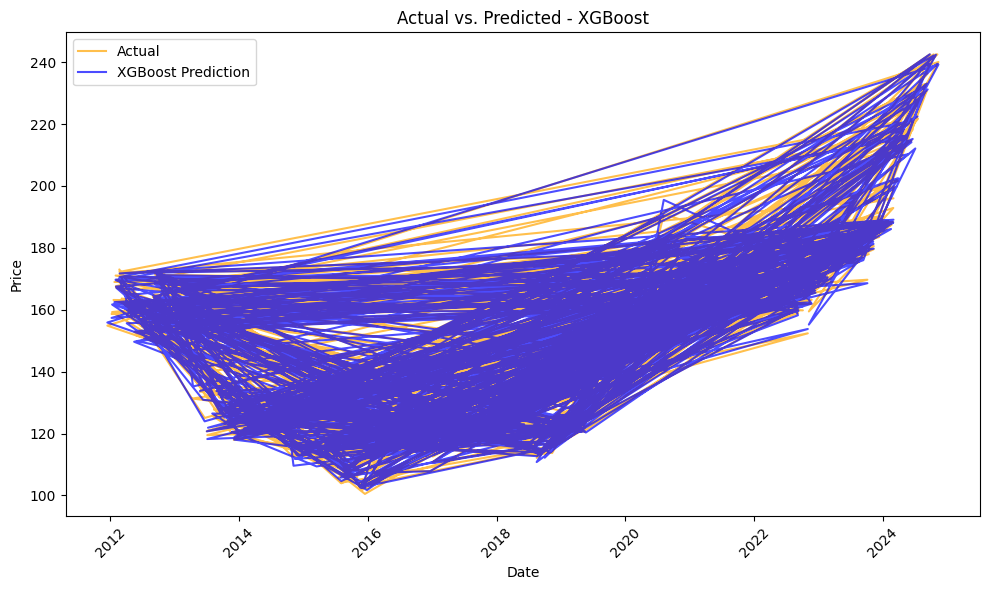

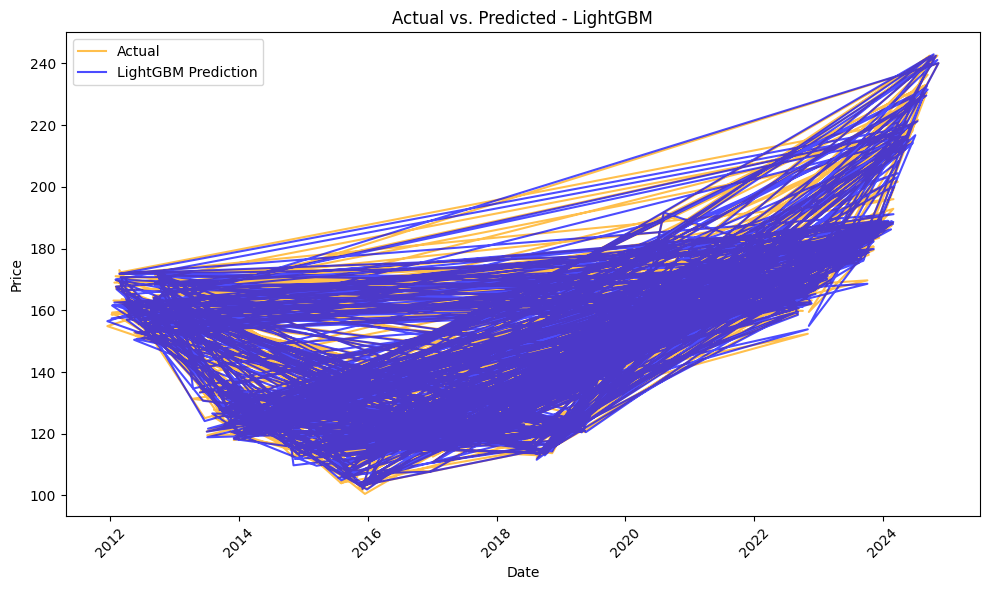

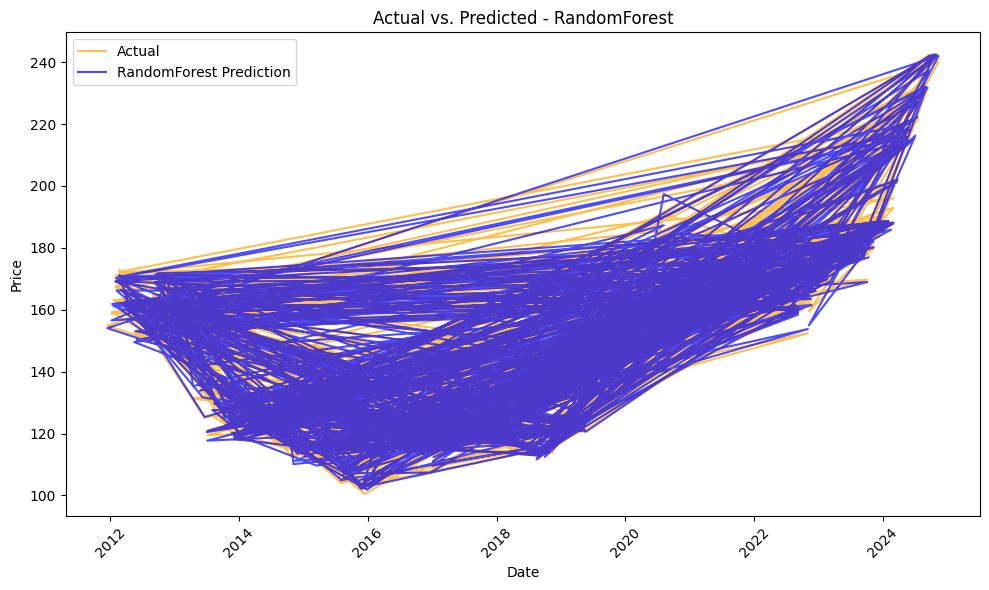

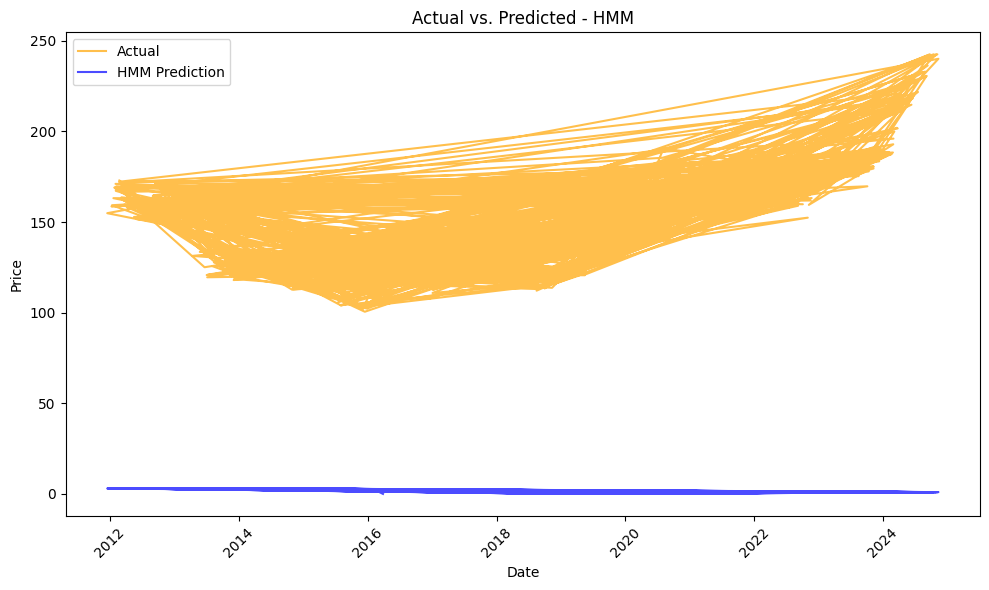

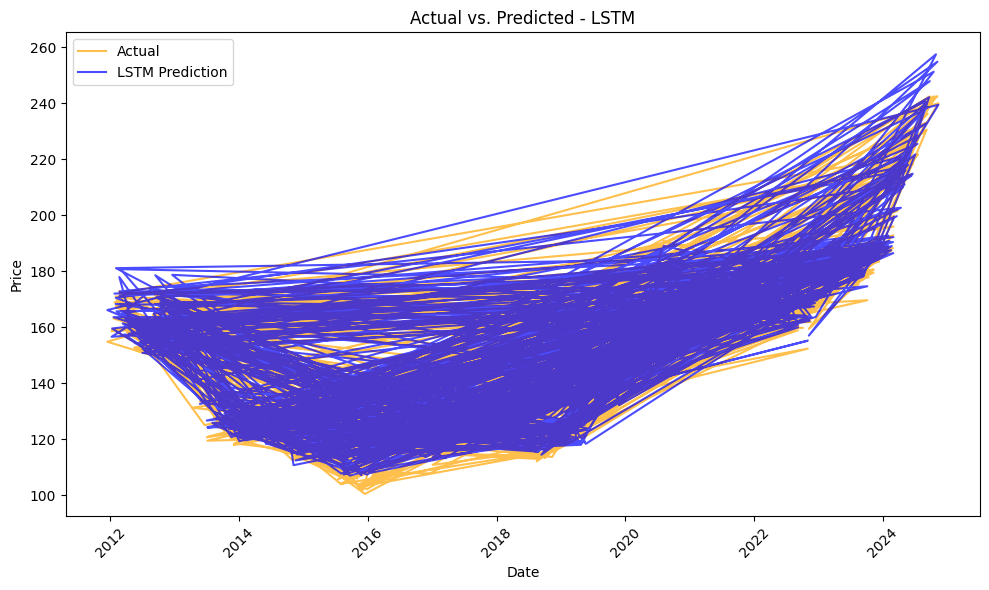

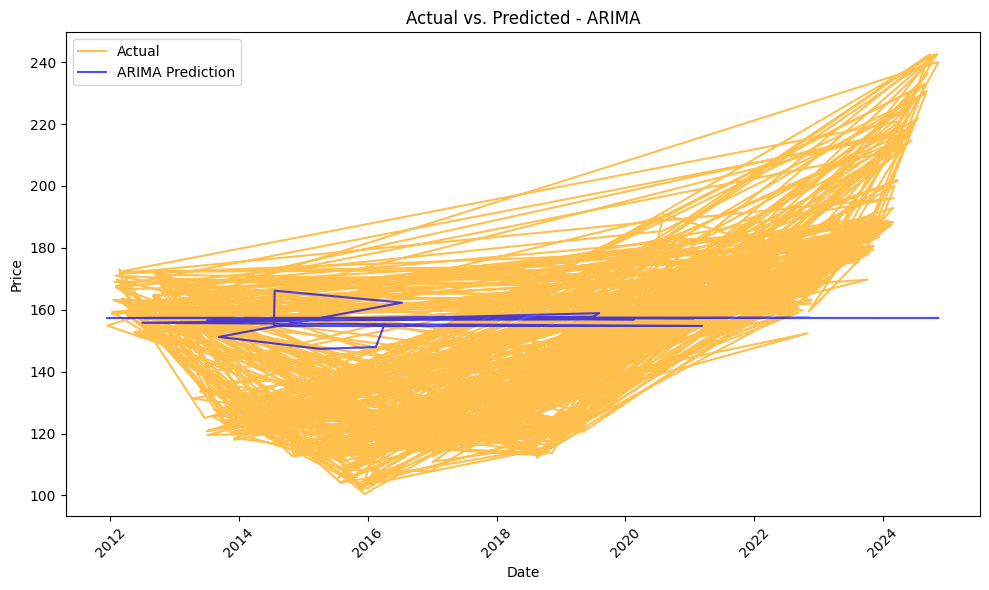

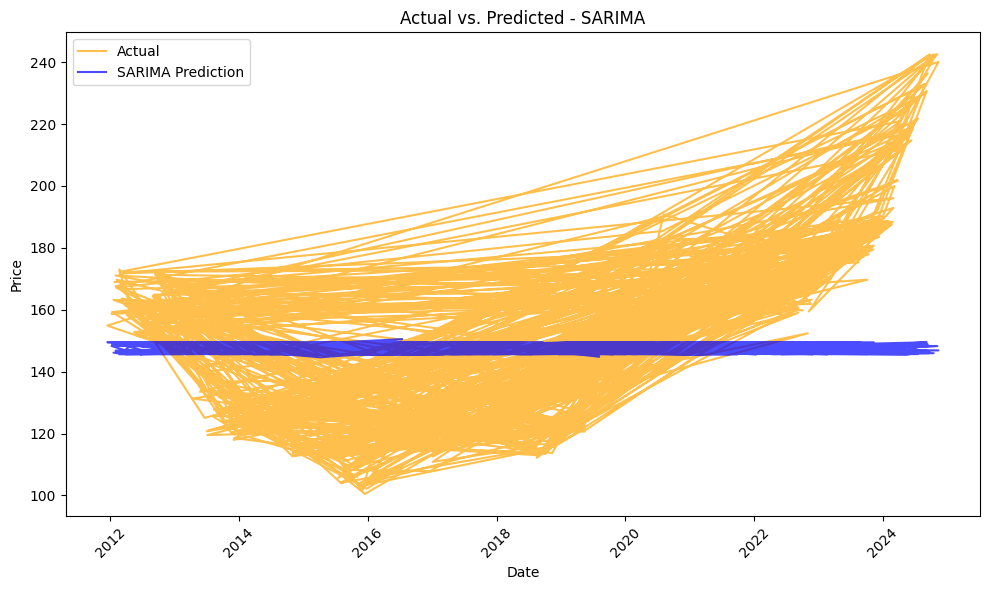


Correct Classifications within Threshold:
XGBoost: 638 correct predictions
LightGBM: 638 correct predictions
RandomForest: 638 correct predictions
HMM: 0 correct predictions
LSTM: 588 correct predictions
ARIMA: 0 correct predictions
SARIMA: 0 correct predictions

Final Model Results:
                       MSE        RMSE         R2         MAE
XGBoost           3.429624    1.851924   0.996318    1.255085
LightGBM          3.184905    1.784630   0.996581    1.237507
RandomForest      3.271139    1.808629   0.996488    1.243962
HMM           22377.140645  149.589908 -23.022419  146.366135
LSTM             17.893805    4.230107   0.980791    3.109600
ARIMA          1016.247904   31.878643  -0.090967   27.068859
SARIMA          934.260613   30.565677  -0.002952   26.520932


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from hmmlearn import hmm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.exceptions import NotFittedError

class ModelTrainer:
    def __init__(self):
        self.scaler = StandardScaler()
        self.correct_classification_threshold = 0.05  # 5% threshold for "correct" predictions

    def prepare_data(self, df):
        # Prepare features and target
        feature_columns = [col for col in df.columns if col != 'close']
        X = df[feature_columns]
        y = df['close'].shift(-1)  # Next day's closing price

        # Remove rows with NaN
        valid_rows = ~(X.isnull().any(axis=1) | y.isnull())
        X = X[valid_rows]
        y = y[valid_rows]

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Scale features
        X_train_scaled = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        X_test_scaled = pd.DataFrame(
            self.scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        
        return X_train_scaled, X_test_scaled, y_train, y_test

    def train_hmm(self, X_train):
        # Hidden Markov Model
        model = hmm.GaussianHMM(n_components=4, covariance_type="diag", n_iter=100)
        model.fit(X_train)
        return model

    def train_lstm(self, X_train, y_train):
        # LSTM Model
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
        model.fit(X_train_lstm, y_train, epochs=10, verbose=0)
        return model

    def train_arima(self, y_train):
        # ARIMA Model
        model = ARIMA(y_train, order=(5, 1, 0))
        model = model.fit()
        return model

    def train_sarima(self, y_train):
        # SARIMA Model
        model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
        model = model.fit()
        return model

    def predict_lstm(self, model, X_test):
        # LSTM Prediction
        X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
        return model.predict(X_test_lstm).flatten()

    def predict_hmm(self, model, X_test):
        # HMM Prediction placeholder
        return model.predict(X_test)
    
    def train_and_evaluate(self, X_train, X_test, y_train, y_test):
    # Define models
     models = {
        'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
        'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
        'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
        'HMM': self.train_hmm(X_train),
        'LSTM': self.train_lstm(X_train, y_train),
        'ARIMA': self.train_arima(y_train),
        'SARIMA': self.train_sarima(y_train)
     }

     results = {}
     predictions = {}
     correct_classifications = {}

     for name, model in models.items():
        try:
            print(f"\nEvaluating {name}...")
            if name == 'LSTM':
                y_pred = self.predict_lstm(model, X_test)
            elif name == 'HMM':
                y_pred = self.predict_hmm(model, X_test)
            elif name in ['ARIMA', 'SARIMA']:
                y_pred = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)

            # Calculate the number of correct predictions within the threshold
            correct_predictions = np.abs((y_test - y_pred) / y_test) <= self.correct_classification_threshold
            correct_classifications[name] = correct_predictions.sum()

            results[name] = {'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAE': mae}
            predictions[name] = y_pred

        except NotFittedError as e:
            print(f"Model {name} was not fitted correctly: {e}")

    # Plot and return results
     self.plot_model_comparison(results)
     self.plot_predictions(y_test, predictions)

     print("\nCorrect Classifications within Threshold:")
     for name, count in correct_classifications.items():
        print(f"{name}: {count} correct predictions")
    
     return results, predictions


    def plot_model_comparison(self, results):
        # Convert results to DataFrame for plotting
        results_df = pd.DataFrame(results).T

        # Create separate subplots for each metric
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        # Plot each metric separately
        results_df['MSE'].plot(kind='bar', ax=axes[0, 0], logy=True, color='skyblue')
        axes[0, 0].set_title('Mean Squared Error (MSE)')
        axes[0, 0].set_ylabel('MSE (log scale)')
        axes[0, 0].tick_params(axis='x', rotation=45)

        results_df['RMSE'].plot(kind='bar', ax=axes[0, 1], color='orange')
        axes[0, 1].set_title('Root Mean Squared Error (RMSE)')
        axes[0, 1].set_ylabel('RMSE')
        axes[0, 1].tick_params(axis='x', rotation=45)

        results_df['R2'].plot(kind='bar', ax=axes[1, 0], color='green')
        axes[1, 0].set_title('R² Score')
        axes[1, 0].set_ylabel('R²')
        axes[1, 0].tick_params(axis='x', rotation=45)

        results_df['MAE'].plot(kind='bar', ax=axes[1, 1], color='purple')
        axes[1, 1].set_title('Mean Absolute Error (MAE)')
        axes[1, 1].set_ylabel('MAE')
        axes[1, 1].tick_params(axis='x', rotation=45)

        # Tight layout for better spacing
        plt.suptitle('Model Comparison by Evaluation Metric')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    
    def plot_predictions(self, y_test, predictions):
        # Iterate through each model and create a separate plot
        for model_name, y_pred in predictions.items():
            plt.figure(figsize=(10, 6))
            plt.plot(y_test.index, y_test.values, label='Actual', color='orange', alpha=0.7, linewidth=1.5)
            plt.plot(y_test.index, y_pred, label=f'{model_name} Prediction', color='blue', alpha=0.7)
            plt.title(f'Actual vs. Predicted - {model_name}')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            
            # Save and display the plot as an individual image
            plt.savefig(f'{model_name}_prediction.png')
            plt.show()



# Usage
# Assuming `final_df` is your prepared DataFrame with a 'close' column
trainer = ModelTrainer()
X_train, X_test, y_train, y_test = trainer.prepare_data(final_df)
results, predictions = trainer.train_and_evaluate(X_train, X_test, y_train, y_test)

# Display final results
print("\nFinal Model Results:")
print(pd.DataFrame(results).T)


In [10]:
class DatePredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.correct_classification_threshold = 0.05  # 5% threshold for "correct" predictions
        self.models = {}  # Store trained models for later use
        self.lstm_model = None  # To store the LSTM model

    def prepare_data(self, df):
        # Prepare features and target
        feature_columns = [col for col in df.columns if col != 'close']
        X = df[feature_columns]
        y = df['close'].shift(-1)  

        # Remove rows with NaN
        valid_rows = ~(X.isnull().any(axis=1) | y.isnull())
        X = X[valid_rows]
        y = y[valid_rows]

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Scale features
        X_train_scaled = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        X_test_scaled = pd.DataFrame(
            self.scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        
        return X_train_scaled, X_test_scaled, y_train, y_test, X, y

    def train_and_store_models(self, X_train, y_train):
        # Define traditional models
        self.models = {
            'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
            'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
            'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
        }

        # Train traditional models
        for name, model in self.models.items():
            print(f"Training {name}...")
            model.fit(X_train, y_train)

        # Train LSTM
        print("Training LSTM...")
        X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))  # Reshape for LSTM
        self.lstm_model = Sequential()
        self.lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
        self.lstm_model.add(LSTM(units=50))
        self.lstm_model.add(Dense(1))
        self.lstm_model.compile(optimizer='adam', loss='mean_squared_error')
        self.lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1)

        print("\nModels trained and stored successfully.")

    def predict_for_date(self, input_date, df):
        # Ensure models are trained
        if not self.models and not self.lstm_model:
            print("Models are not trained yet. Train models before predicting.")
            return None

        # Prepare data for the given date
        if input_date not in df.index:
            print("Error: Given date not found in the dataset.")
            return None

        # Extract the feature data for the given date
        input_data = df.loc[input_date].drop('close')
        input_data_scaled = self.scaler.transform(input_data.values.reshape(1, -1))

        # Generate predictions using each model
        predictions = {}
        for name, model in self.models.items():
            predictions[name] = model.predict(input_data_scaled)[0]

        # Predict using LSTM
        input_data_lstm = input_data_scaled.reshape((1, 1, input_data_scaled.shape[1]))
        predictions['LSTM'] = self.lstm_model.predict(input_data_lstm)[0][0]

        return predictions

# Usage
# Assuming `final_df` is your prepared DataFrame with a 'close' column
trainer = DatePredictor()
X_train, X_test, y_train, y_test, X, y = trainer.prepare_data(final_df)
trainer.train_and_store_models(X_train, y_train)

# User Input Prediction
user_date = '2012-02-08'  # Replace with the desired date input
predictions = trainer.predict_for_date(user_date, final_df)

if predictions:
    print(f"\nPredictions for {user_date}:")
    for model, pred in predictions.items():
        print(f"{model}: {pred:.2f}")


Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3568
[LightGBM] [Info] Number of data points in the train set: 2554, number of used features: 14
[LightGBM] [Info] Start training from score 147.335887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 22536.6309
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21658.7754
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18849.6191
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16731.6113
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16071.8896
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15183.6348
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14154.9775
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13319.7578
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12590.7803
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12066.0938
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11320.2520
Epoch 12/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10857.7109
Epoch 13/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10043.7832
Epoch 14/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9527.5615
Epoch 15/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step

Predictions for 2012-02-08:
XGBoost: 169.27
LightGBM: 169.02
RandomForest: 168.63
LSTM: 71.94


dsdh

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import joblib
import os

class DatePredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.correct_classification_threshold = 0.05
        self.models = {}
        self.model_directory = 'E:\gf'
        
        # Create directory for saving models if it doesn't exist
        if not os.path.exists(self.model_directory):
            os.makedirs(self.model_directory)
        
    def prepare_data(self, df):
        feature_columns = [col for col in df.columns if col != 'close']
        X = df[feature_columns]
        y = df['close'].shift(-1)  

        valid_rows = ~(X.isnull().any(axis=1) | y.isnull())
        X = X[valid_rows]
        y = y[valid_rows]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train_scaled = pd.DataFrame(
            self.scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        X_test_scaled = pd.DataFrame(
            self.scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        
        # Save the scaler
        joblib.dump(self.scaler, os.path.join(self.model_directory, 'scaler.joblib'))
        
        return X_train_scaled, X_test_scaled, y_train, y_test, X, y

    def train_and_store_models(self, X_train, y_train):
        self.models = {
            'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
            'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
        }

        # Train and save each model
        for name, model in self.models.items():
            print(f"Training {name} model...")
            model.fit(X_train, y_train)
            
            # Save the trained model
            model_path = os.path.join(self.model_directory, f'{name.lower()}_model.joblib')
            joblib.dump(model, model_path)
            print(f"Saved {name} model to {model_path}")

    def load_models(self):
        """Load all saved models and scaler"""
        try:
            # Load the scaler
            self.scaler = joblib.load(os.path.join(self.model_directory, 'scaler.joblib'))
            
            # Load all models
            self.models = {
                'XGBoost': joblib.load(os.path.join(self.model_directory, 'xgboost_model.joblib')),
                'RandomForest': joblib.load(os.path.join(self.model_directory, 'randomforest_model.joblib'))
            }
            print("Successfully loaded all models and scaler")
            return True
        except Exception as e:
            print(f"Error loading models: {str(e)}")
            return False

    def predict_for_date(self, input_date, df):
        # Load models if they haven't been loaded yet
        if not self.models:
            if not self.load_models():
                raise Exception("Models could not be loaded. Please ensure models are trained first.")

        input_data = df.loc[input_date].drop('close')
        input_data_scaled = self.scaler.transform(input_data.values.reshape(1, -1))

        predictions = {}
        for name, model in self.models.items():
            predictions[name] = model.predict(input_data_scaled)[0]

        return predictions

# Usage example
def main():
    # Assuming final_df is your prepared DataFrame
    trainer = DatePredictor()
    
    # Training phase
    print("Starting training phase...")
    X_train, X_test, y_train, y_test, X, y = trainer.prepare_data(final_df)
    trainer.train_and_store_models(X_train, y_train)
    print("Training complete and models saved")
    
    # Prediction phase
    print("\nStarting prediction phase...")
    user_date = '2022-02-08'  # Replace with desired date
    
    # Create a new predictor instance (simulating a new session)
    predictor = DatePredictor()
    predictions = predictor.predict_for_date(user_date, final_df)
    
    # Print predictions
    print("\nPredictions for", user_date)
    for model_name, prediction in predictions.items():
        print(f"{model_name}: {prediction:.2f}")

if __name__ == "__main__":
    main()

Starting training phase...
Training XGBoost model...
Saved XGBoost model to E:\gf\xgboost_model.joblib
Training RandomForest model...
Saved RandomForest model to E:\gf\randomforest_model.joblib
Training complete and models saved

Starting prediction phase...
Successfully loaded all models and scaler

Predictions for 2022-02-08
XGBoost: 170.03
RandomForest: 169.94


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
